In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy.polynomial.polynomial as poly
import pandas as pd
import scipy as sp
import matplotlib.cm as cmap
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from matplotlib import pylab
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from scipy import stats
from sklearn.decomposition import KernelPCA
from sklearn.decomposition import NMF#
from sklearn.decomposition import FactorAnalysis
from sklearn.manifold import TSNE#
from sklearn.preprocessing import RobustScaler#
from sklearn.decomposition import FastICA

In [2]:
df = pd.read_excel('titanic3.xls')
df.head()

pclass  survived                                             name     sex  \
0       1         1                    Allen, Miss. Elisabeth Walton  female   
1       1         1                   Allison, Master. Hudson Trevor    male   
2       1         0                     Allison, Miss. Helen Loraine  female   
3       1         0             Allison, Mr. Hudson Joshua Creighton    male   
4       1         0  Allison, Mrs. Hudson J C (Bessie Waldo Daniels)  female   

       age  sibsp  parch  ticket      fare    cabin embarked boat   body  \
0  29.0000      0      0   24160  211.3375       B5        S    2    NaN   
1   0.9167      1      2  113781  151.5500  C22 C26        S   11    NaN   
2   2.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   
3  30.0000      1      2  113781  151.5500  C22 C26        S  NaN  135.0   
4  25.0000      1      2  113781  151.5500  C22 C26        S  NaN    NaN   

                         home.dest  
0                     St Louis, MO  
1  Montreal, PQ / Chesterville, ON  
2  Montreal, PQ / Chesterville, ON  
3  Montreal, PQ / Chesterville, ON  
4  Montreal, PQ / Chesterville, ON

Задача - спрогнозировать, виживет ли человек на Титанике по его характеристикам
## Описание переменных

*pclass* – Класс

*survived* – Бинарная переменная: 1 - выжил, 0 - погиб

*name* – Имя пассажира

*sex* – пол пассажира

*age* – Возраст

*sibsp* – Количество братьев или сестер (родных, сводных и тд)

*parch* – Количество родителей или детей у этого человека на борту

*ticket* – Номер билета

*fare* – Цена билета

*cabin* – Кабина 

*embarked* – Название порта, в котором пассажир зашел на борт (C — Шербур, Q — Квинстаун, S — Саутгемптон)

*boat* – Номер лодки

*body* – Номер тела 

*home.dest* – Адрес 

In [3]:
df.shape

(1309, 14)

In [4]:
# выкидываем нечисловые признаки и меняем колонку пол в числовой формат
df['sex'].replace(['female','male'], [0,1], inplace=True)
df.drop(['name', 'home.dest', 'cabin', 'embarked', 'ticket'], axis=1, inplace=True)
df.head()

pclass  survived  sex      age  sibsp  parch      fare boat   body
0       1         1    0  29.0000      0      0  211.3375    2    NaN
1       1         1    1   0.9167      1      2  151.5500   11    NaN
2       1         0    0   2.0000      1      2  151.5500  NaN    NaN
3       1         0    1  30.0000      1      2  151.5500  NaN  135.0
4       1         0    0  25.0000      1      2  151.5500  NaN    NaN

In [5]:
# признаки body и boat содержат слишком много пропусков, поэтому их следует удалить
df.drop(['body', 'boat'], axis=1, inplace=True)
df.head()

pclass  survived  sex      age  sibsp  parch      fare
0       1         1    0  29.0000      0      0  211.3375
1       1         1    1   0.9167      1      2  151.5500
2       1         0    0   2.0000      1      2  151.5500
3       1         0    1  30.0000      1      2  151.5500
4       1         0    0  25.0000      1      2  151.5500

In [6]:
# Теперь у нас пропуски только в признаках возраст и цена билета
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 7 columns):
pclass      1309 non-null int64
survived    1309 non-null int64
sex         1309 non-null int64
age         1046 non-null float64
sibsp       1309 non-null int64
parch       1309 non-null int64
fare        1308 non-null float64
dtypes: float64(2), int64(5)
memory usage: 71.7 KB


In [7]:
#Удалим строки с пропусками
df.dropna(axis=0, inplace=True)
df.index = np.arange(len(df))
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1045 entries, 0 to 1044
Data columns (total 7 columns):
pclass      1045 non-null int64
survived    1045 non-null int64
sex         1045 non-null int64
age         1045 non-null float64
sibsp       1045 non-null int64
parch       1045 non-null int64
fare        1045 non-null float64
dtypes: float64(2), int64(5)
memory usage: 65.3 KB


In [8]:
df

pclass  survived  sex      age  sibsp  parch      fare
0          1         1    0  29.0000      0      0  211.3375
1          1         1    1   0.9167      1      2  151.5500
2          1         0    0   2.0000      1      2  151.5500
3          1         0    1  30.0000      1      2  151.5500
4          1         0    0  25.0000      1      2  151.5500
...      ...       ...  ...      ...    ...    ...       ...
1040       3         0    1  45.5000      0      0    7.2250
1041       3         0    0  14.5000      1      0   14.4542
1042       3         0    1  26.5000      0      0    7.2250
1043       3         0    1  27.0000      0      0    7.2250
1044       3         0    1  29.0000      0      0    7.8750

[1045 rows x 7 columns]

In [9]:
# таблица с описательными статистиками
df.describe()

pclass     survived          sex          age        sibsp  \
count  1045.000000  1045.000000  1045.000000  1045.000000  1045.000000   
mean      2.206699     0.408612     0.628708    29.851834     0.503349   
std       0.841542     0.491813     0.483382    14.389201     0.912471   
min       1.000000     0.000000     0.000000     0.166700     0.000000   
25%       1.000000     0.000000     0.000000    21.000000     0.000000   
50%       2.000000     0.000000     1.000000    28.000000     0.000000   
75%       3.000000     1.000000     1.000000    39.000000     1.000000   
max       3.000000     1.000000     1.000000    80.000000     8.000000   

             parch         fare  
count  1045.000000  1045.000000  
mean      0.421053    36.686080  
std       0.840052    55.732533  
min       0.000000     0.000000  
25%       0.000000     8.050000  
50%       0.000000    15.750000  
75%       1.000000    35.500000  
max       6.000000   512.329200

### Визуализация данных 2D

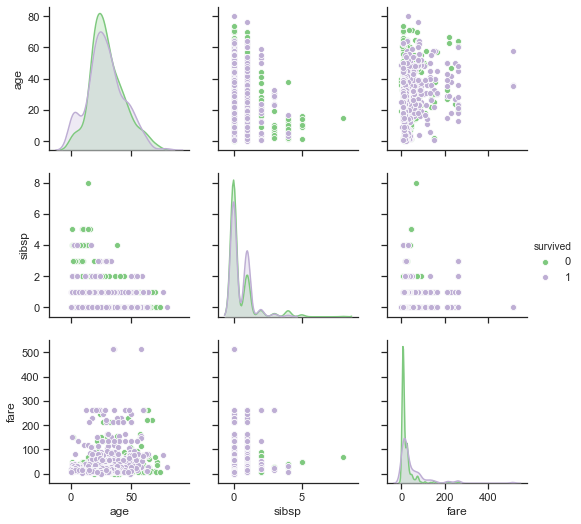

In [10]:
import seaborn as sns #хороший пакет для визуализации https://seaborn.pydata.org/tutorial/axis_grids.html 
sns.set(style="ticks")
g = sns.pairplot(df, hue="survived", vars=['age','sibsp','fare'], palette="Accent", height=2.5)

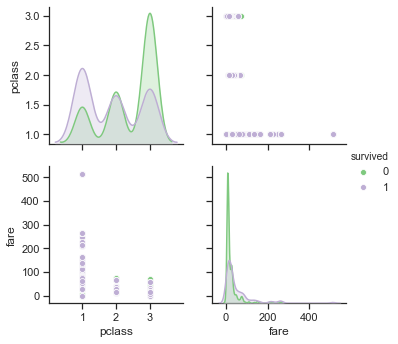

In [11]:
sns.set(style="ticks")
m = sns.pairplot(df, hue="survived", vars=['pclass','fare'], palette="Accent", height=2.5)

Text(0.5, 1.0, 'Выжившие по полу')

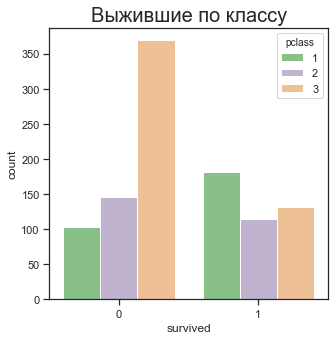

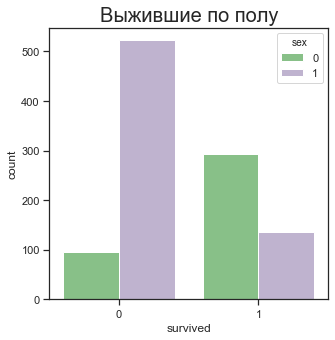

In [12]:
plt.figure(figsize=(5,5))
sns.countplot(x = 'survived', palette="Accent",hue = 'pclass', data = df)
plt.title("Выжившие по классу",size=20)
plt.figure(figsize=(5,5))
sns.countplot(x = 'survived', palette="Accent", hue = 'sex', data = df)
plt.title("Выжившие по полу",size=20)

### Визуализация данных 3D

In [13]:
# Создали датафреймы для признаков и зависимой переменной
dff = pd.DataFrame(df, columns=['pclass', 'sex', 'age', 'sibsp', 'parch', 'fare'])
y = pd.DataFrame(df, columns=['survived'])

In [14]:
y

survived
0            1
1            1
2            0
3            0
4            0
...        ...
1040         0
1041         0
1042         0
1043         0
1044         0

[1045 rows x 1 columns]

In [15]:
dff

pclass  sex      age  sibsp  parch      fare
0          1    0  29.0000      0      0  211.3375
1          1    1   0.9167      1      2  151.5500
2          1    0   2.0000      1      2  151.5500
3          1    1  30.0000      1      2  151.5500
4          1    0  25.0000      1      2  151.5500
...      ...  ...      ...    ...    ...       ...
1040       3    1  45.5000      0      0    7.2250
1041       3    0  14.5000      1      0   14.4542
1042       3    1  26.5000      0      0    7.2250
1043       3    1  27.0000      0      0    7.2250
1044       3    1  29.0000      0      0    7.8750

[1045 rows x 6 columns]

In [17]:
# Посмотрим расположение данных  в 3д
label = np.unique(pd.DataFrame(df, columns=['survived']))
y_a = y.values
y_a = y_a[:,0]

def threeD_data (data, el, az, a, b, c, title, axes_x, axes_y, axes_z):
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=el, azim=az)
    colors = ['salmon', 'lightseagreen']
    
    for name, label in [('0', 0), ('1', 1)]:
        ax.text3D(data.values[y_a == label, a].mean(),    #a,b,c - номера столбцов, которые мы хотим отразить на осях
                  data.values[y_a == label, b].mean() + 1.0,
                  data.values[y_a == label, c].mean(), name,
                  horizontalalignment='center')
    yy = np.choose(df['survived'].values, colors)        # Один список используется для индексации элементов из второго списка
    for i, target_name in zip([0, 1], np.array(['погиб', 'выжил'])):
        ax.scatter(data.values[y_a == i,a], 
                   data.values[y_a == i,b], 
                   data.values[y_a == i,c], c=colors[i], s=50, cmap=plt.cm.spring, alpha=1, edgecolor='black', label=target_name)
    plt.legend(loc='best', shadow=False, scatterpoints=1)
    ax.set_xlabel(axes_x)                                 # подписываем оси
    ax.set_ylabel(axes_y)
    ax.set_zlabel(axes_z)
    plt.title(title)

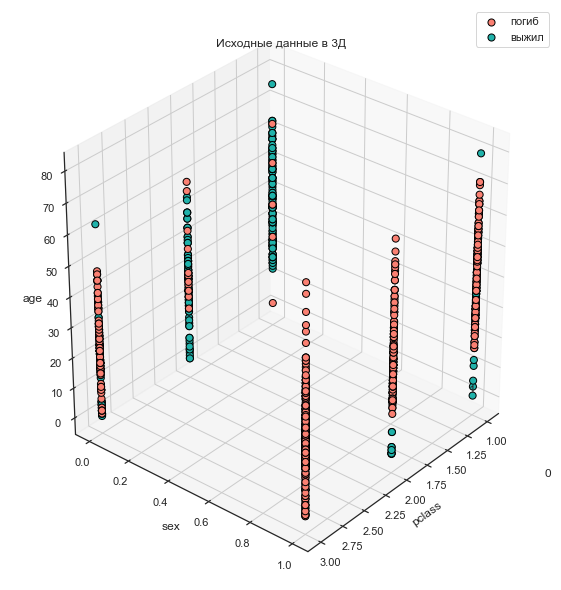

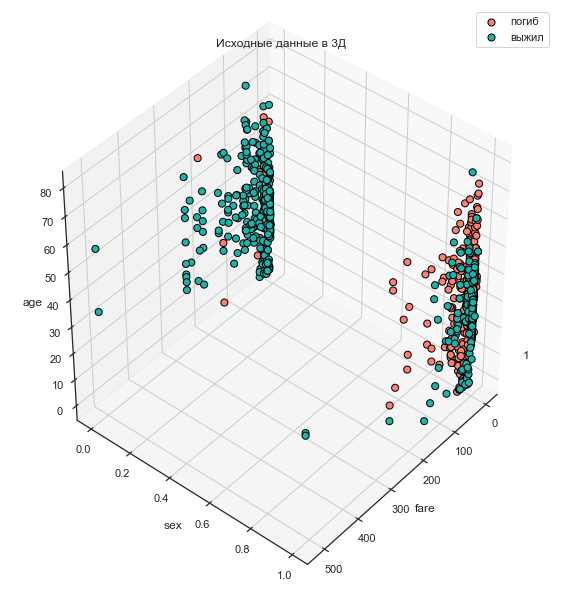

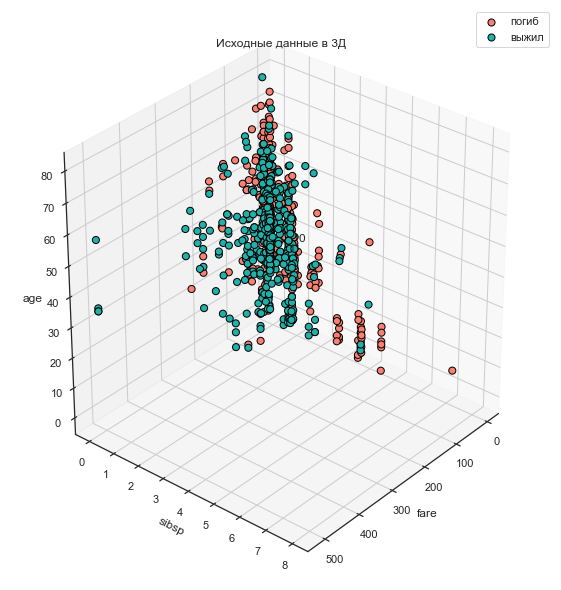

In [18]:
# Про 3д визуализацию https://medium.com/@yzhong.cs/beyond-data-scientist-3d-plots-in-python-with-examples-2a8bd7aa654b
threeD_data (dff, 30, 40, 0, 1, 2, "Исходные данные в 3Д", 'pclass', 'sex', 'age')
threeD_data (dff, 40, 40, 5, 1, 2, "Исходные данные в 3Д", 'fare', 'sex', 'age')
threeD_data (dff, 30, 40, 5, 3, 2, "Исходные данные в 3Д", 'fare', 'sibsp', 'age')

In [21]:
# Стандартизируем данные, теперь дисперсия = 1
dff_st_a = preprocessing.scale(dff, with_mean = False) 
dff_st = pd.DataFrame(dff_st_a)
# Стандартизируем и нормируем
dff_st_norm_a = preprocessing.scale(dff) 
dff_st_norm = pd.DataFrame(dff_st_norm_a)

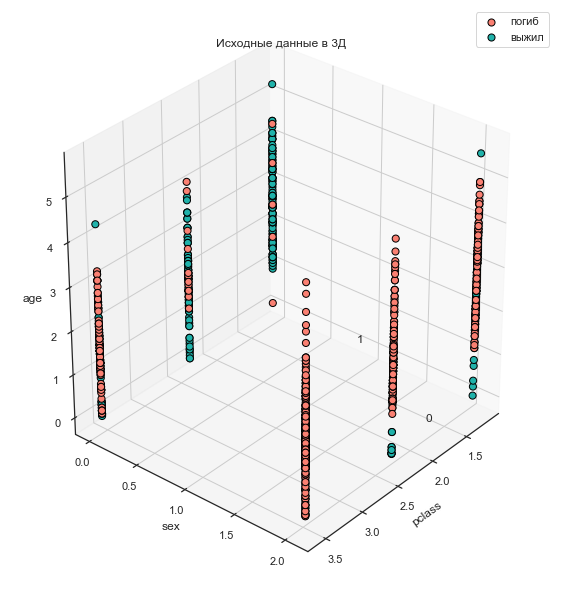

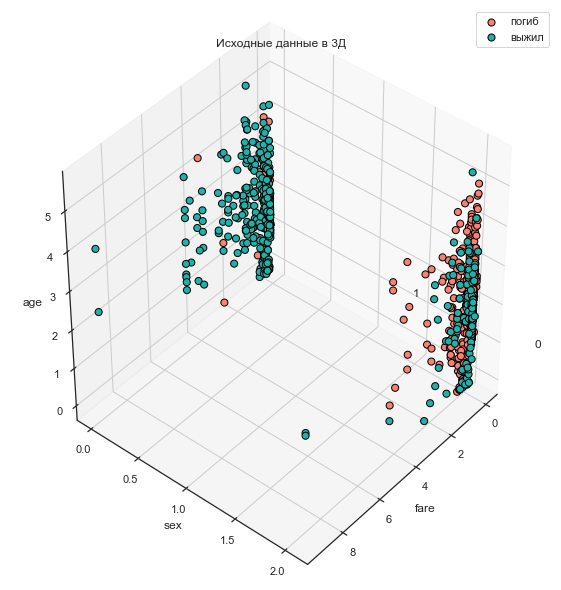

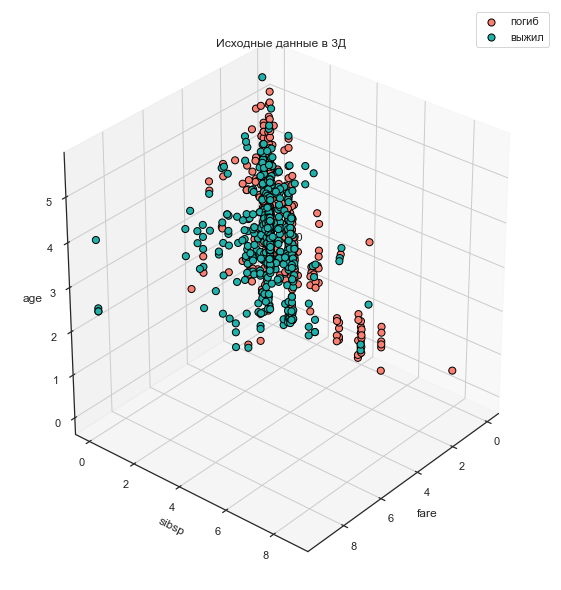

In [20]:
# На стандартизированных данных
threeD_data (dff_st, 30, 40, 0, 1, 2, "Исходные данные в 3Д", 'pclass', 'sex', 'age')
threeD_data (dff_st, 40, 40, 5, 1, 2, "Исходные данные в 3Д", 'fare', 'sex', 'age')
threeD_data (dff_st, 30, 40, 5, 3, 2, "Исходные данные в 3Д", 'fare', 'sibsp', 'age')
# Гравики почти не изменились

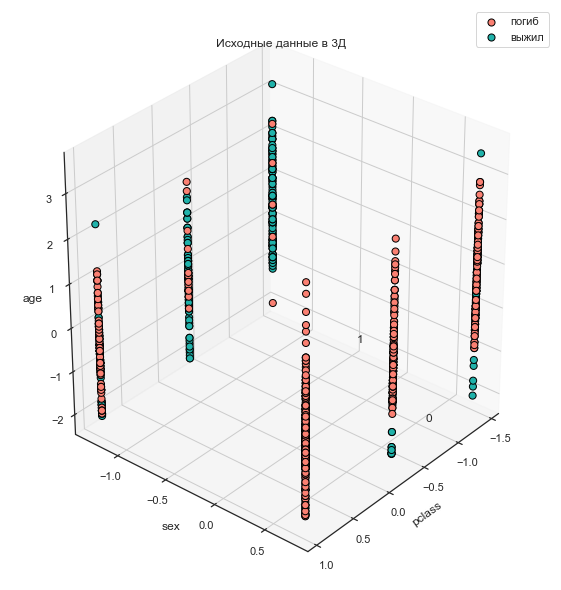

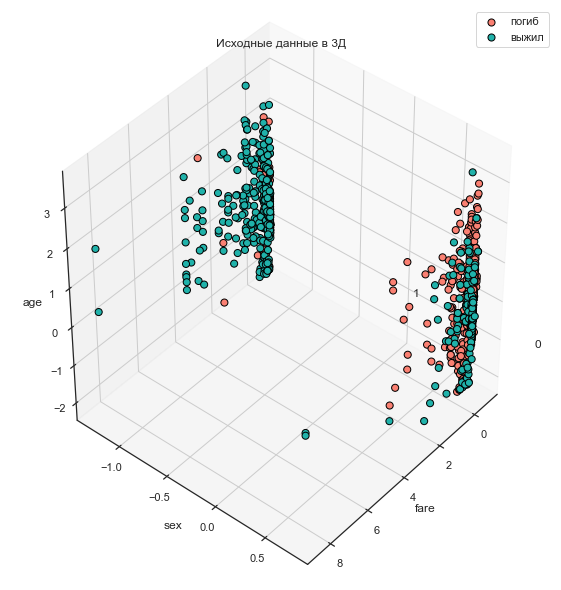

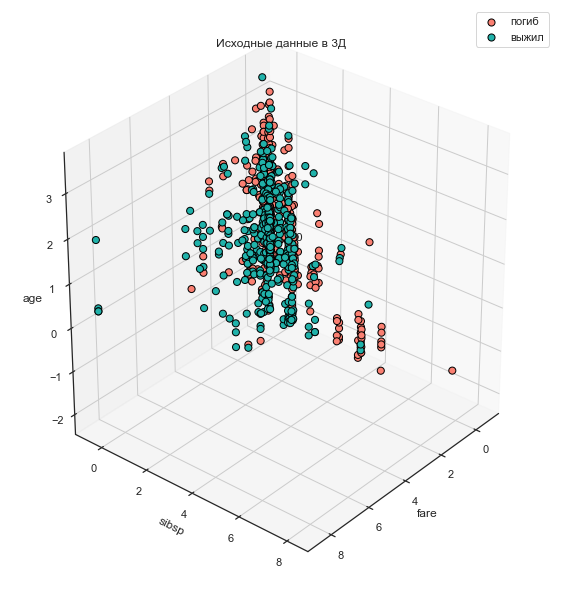

In [21]:
# На стандартизированных и нормированных данных
threeD_data (dff_st_norm, 30, 40, 0, 1, 2, "Исходные данные в 3Д", 'pclass', 'sex', 'age')
threeD_data (dff_st_norm, 40, 40, 5, 1, 2, "Исходные данные в 3Д", 'fare', 'sex', 'age')
threeD_data (dff_st_norm, 30, 40, 5, 3, 2, "Исходные данные в 3Д", 'fare', 'sibsp', 'age')

### Метод главных компонент

In [16]:
def pca_model (data, a):
    pca = PCA(n_components = a)
    pca.fit_transform(data)
    print(pca.explained_variance_ratio_)
    print(pca.singular_values_)
    return pca.fit_transform(data)

In [17]:
pca_model (dff, 1)

[0.93902437]
[1802.90424462]


array([[174.39822916],
       [113.30961596],
       [113.36460342],
       ...,
       [-29.59898694],
       [-29.57435395],
       [-28.82664116]])

In [18]:
pca_model (dff, 2)

[0.93902437 0.06036196]
[1802.90424462  457.10493236]


array([[174.39822916,  -9.43091558],
       [113.30961596, -34.55751193],
       [113.36460342, -33.47937939],
       ...,
       [-29.59898694,  -1.89275462],
       [-29.57435395,  -1.39356363],
       [-28.82664116,   0.5711404 ]])

In [38]:
m = pca_model (dff, 2)

[0.93902437 0.06036196]
[1802.90424462  457.10493236]


In [19]:
X1 = pca_model (dff, 6)
X1 = pd.DataFrame(data=X1)

[9.39024371e-01 6.03619632e-02 2.83524079e-04 1.45268414e-04
 1.22648922e-04 6.22242654e-05]
[1802.90424462  457.10493236   31.32774992   22.42434811   20.60469058
   14.67621679]


In [22]:
X2 = pca_model (dff_st, 6)
X2 = pd.DataFrame(data=X2)

[0.30751701 0.27667833 0.14772865 0.11106301 0.09723149 0.05978151]
[43.91049574 41.65060815 30.43449747 26.38872974 24.69091863 19.3605281 ]


In [23]:
X3 = pca_model (dff_st_norm, 6)
X3 = pd.DataFrame(data=X3)

[0.30751701 0.27667833 0.14772865 0.11106301 0.09723149 0.05978151]
[43.91049574 41.65060815 30.43449747 26.38872974 24.69091863 19.3605281 ]


#### Визуализация главных компонент

(-65.46823977198198,
 505.0219988440483,
 -39.649982142341884,
 55.526553633665806)

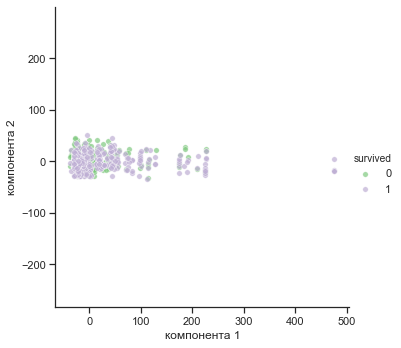

In [28]:
#Через seaborn
X1_y = pd.concat([X1, y], axis=1, ignore_index = False, join = 'inner') 
X1_y = X1_y.rename(columns={ X1_y.columns[0]: "компонента 1"})
X1_y = X1_y.rename(columns={ X1_y.columns[1]: "компонента 2"})

g = sns.FacetGrid(X1_y, hue='survived', palette='Accent', height=5)
g.map(plt.scatter, "компонента 1", "компонента 2", s=30, alpha=.7, linewidth=.5, edgecolor="white")
g.add_legend()
plt.axis("equal")

Text(0.5, 1.0, 'PCA 2 компоненты')

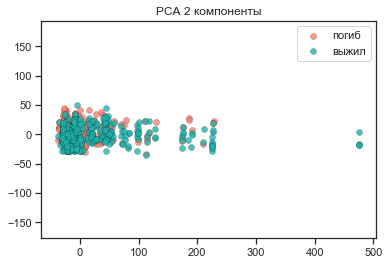

In [29]:
# Через plt
X1_a = X1.values


colors = ['salmon', 'lightseagreen']
lw = 0.2

for color, i, target_name in zip(colors, [0, 1], np.array(['погиб', 'выжил'])):
    plt.scatter(X1_a[y_a == i, 0], X1_a[y_a == i, 1], color=color, alpha=.8, lw=lw,edgecolor='black',
                label=target_name)
plt.axis("equal")
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA 2 компоненты')

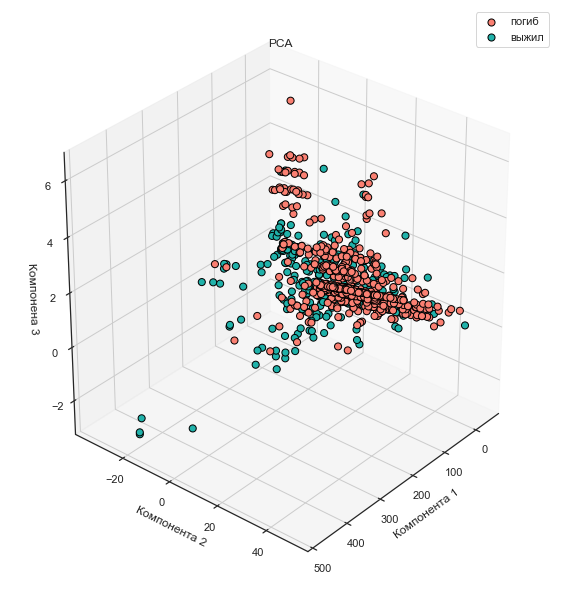

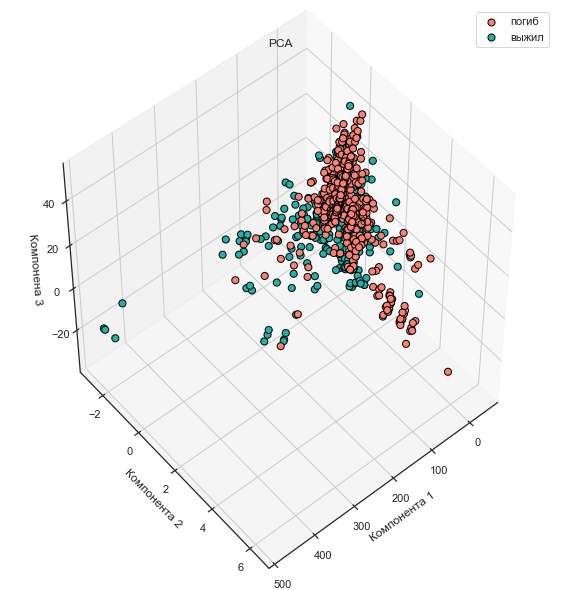

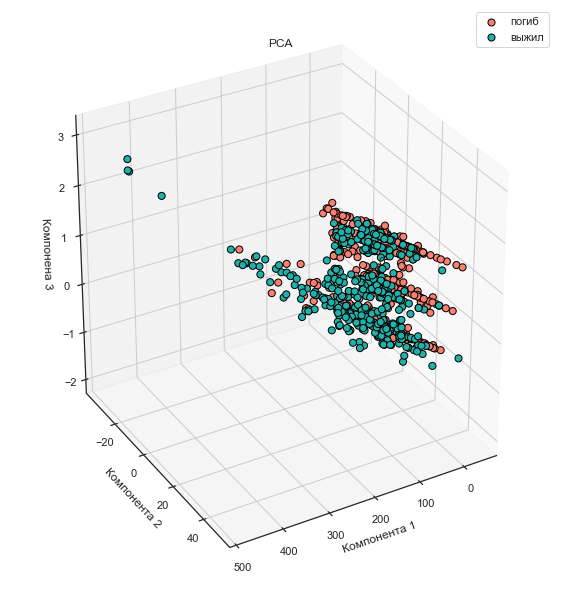

In [30]:
threeD_data (X1, 30, 40, 0, 1, 2, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X1, 50, 50, 0, 2, 1, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X1, 30, 60, 0, 1, 4, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')

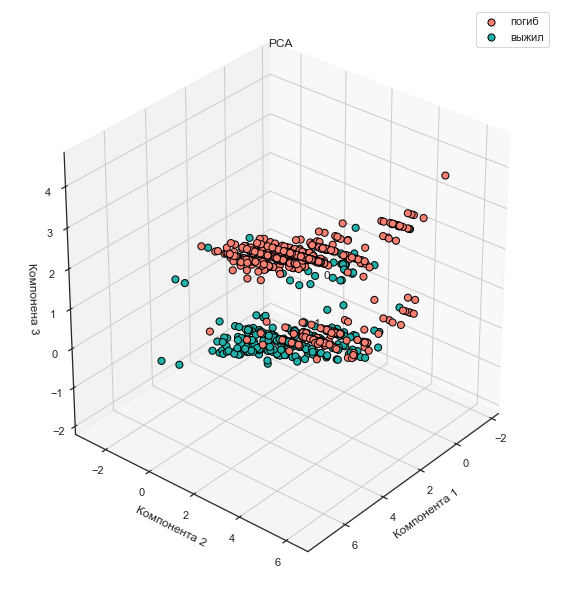

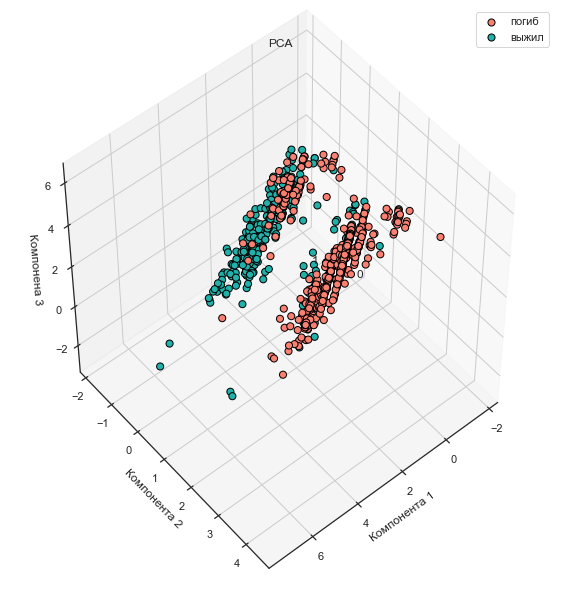

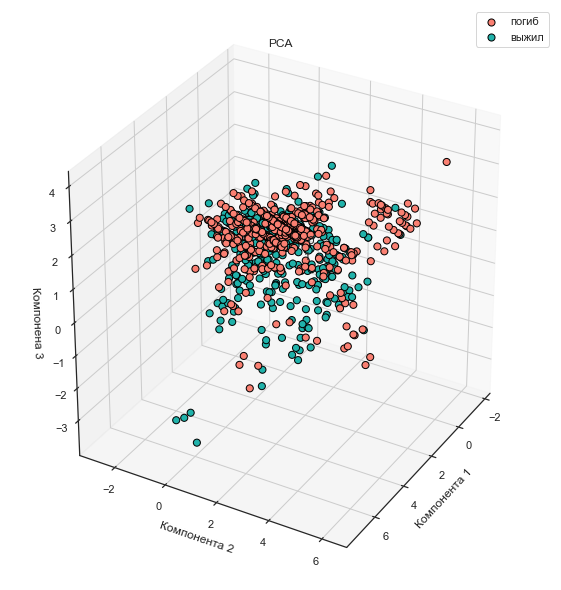

In [31]:
threeD_data (X2, 30, 40, 0, 1, 2, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X2, 50, 50, 0, 2, 1, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X2, 30, 30, 0, 1, 4, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
# Заметно более чёткое разделение на группы

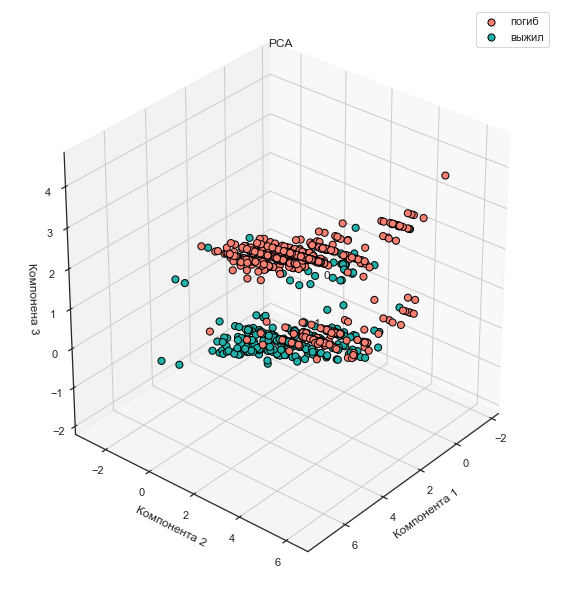

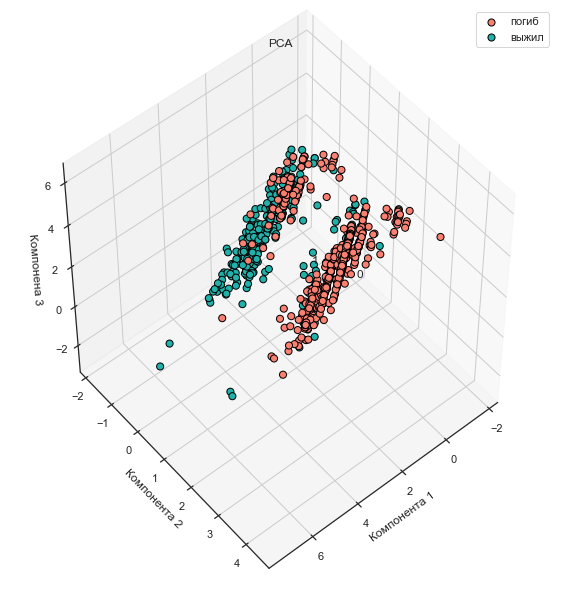

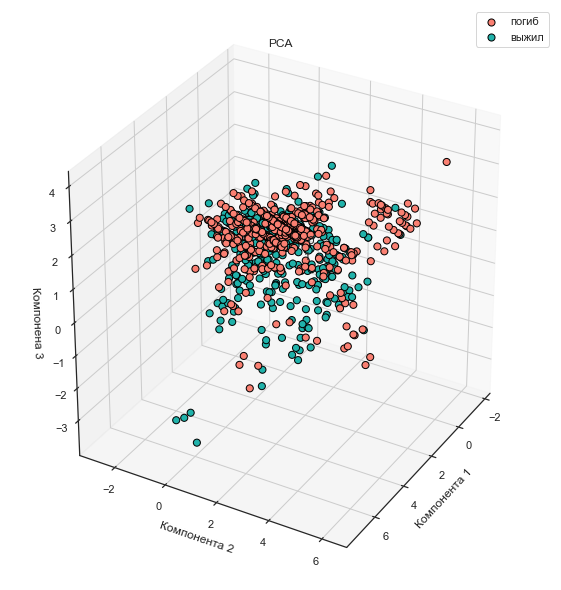

In [32]:
threeD_data (X3, 30, 40, 0, 1, 2, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X3, 50, 50, 0, 2, 1, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X3, 30, 30, 0, 1, 4, "PCA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
# Тоже чёткое разделение

### Факторный анализ

In [24]:
def fa_model (data, a):
    fa = FactorAnalysis(n_components = a)
    fa.fit_transform(data)
    return fa.fit_transform(data)

In [25]:
fa_model (dff, 1)

array([[ 3.13417399],
       [ 2.06144106],
       [ 2.06164056],
       ...,
       [-0.52914758],
       [-0.5291445 ],
       [-0.51746998]])

In [26]:
X11 = fa_model (dff, 6)
X11 = pd.DataFrame(data=X1)
X22 = fa_model (dff_st, 6)
X22 = pd.DataFrame(data=X2)
X33 = fa_model (dff_st_norm, 6)
X33 = pd.DataFrame(data=X3)

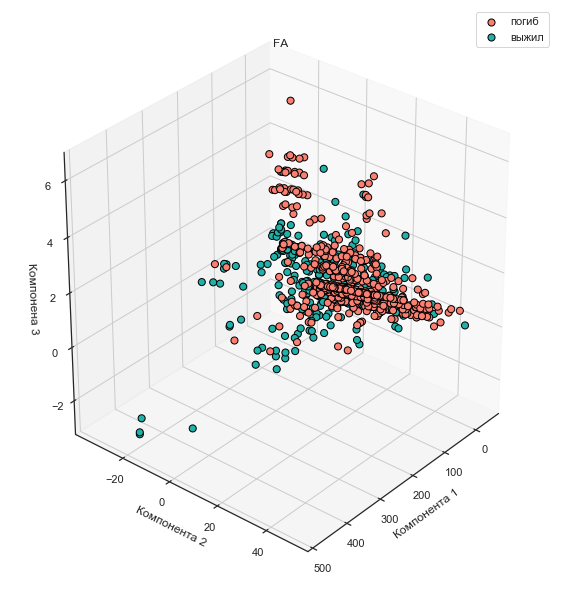

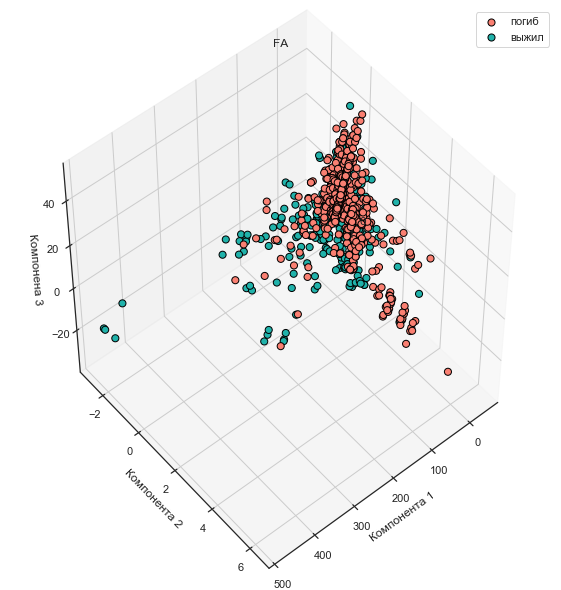

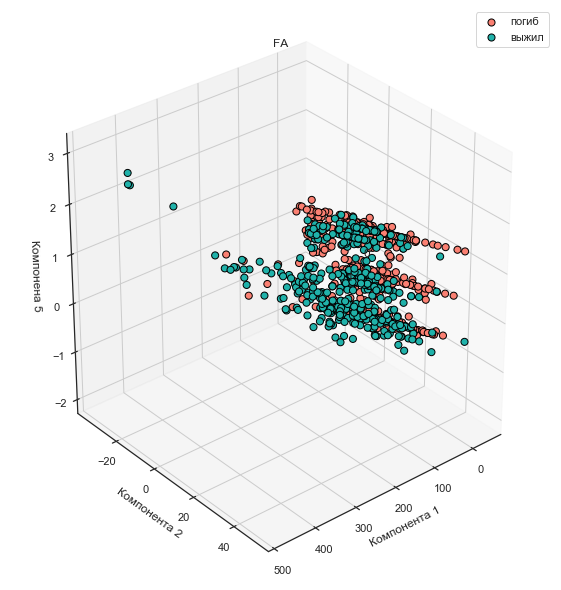

In [37]:
threeD_data (X11, 30, 40, 0, 1, 2, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X11, 50, 50, 0, 2, 1, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X11, 30, 50, 0, 1, 4, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')

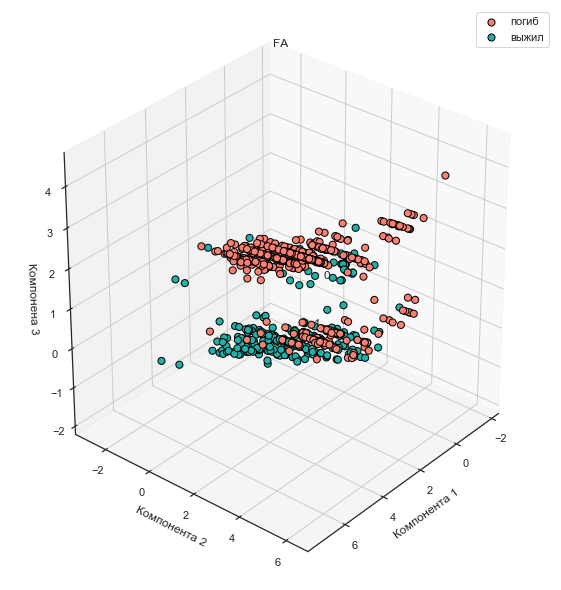

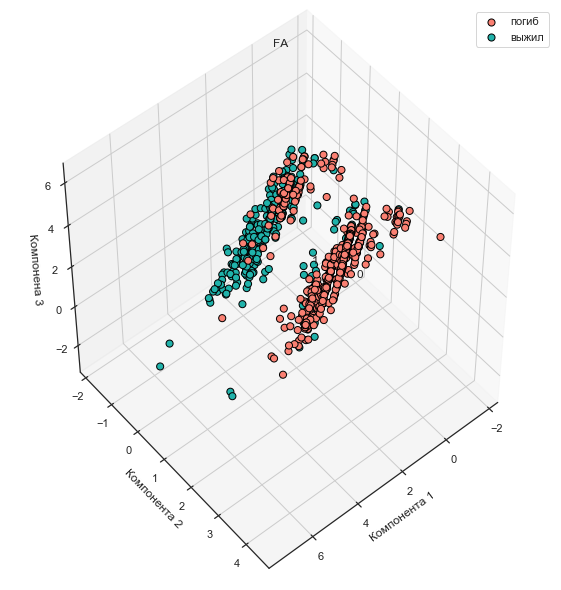

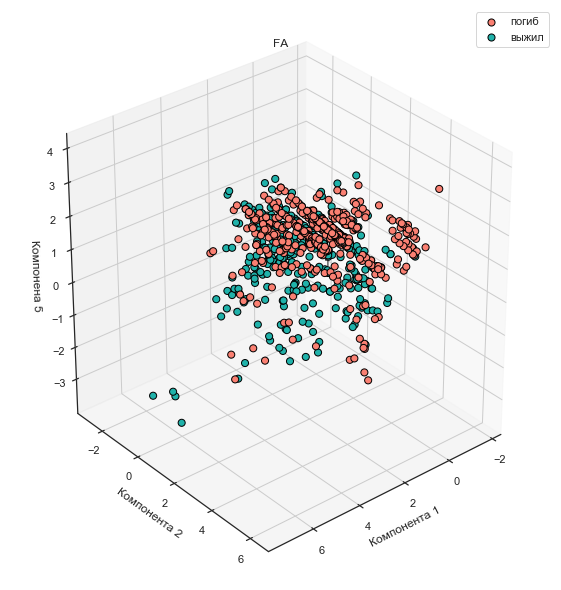

In [38]:
threeD_data (X22, 30, 40, 0, 1, 2, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X22, 50, 50, 0, 2, 1, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X22, 30, 50, 0, 1, 4, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')

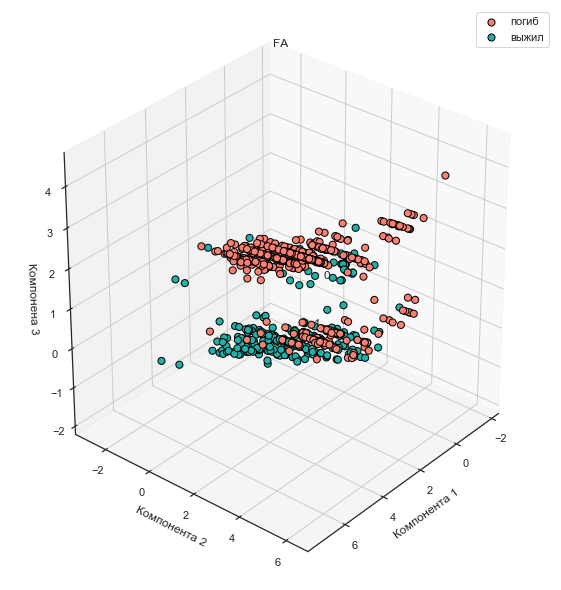

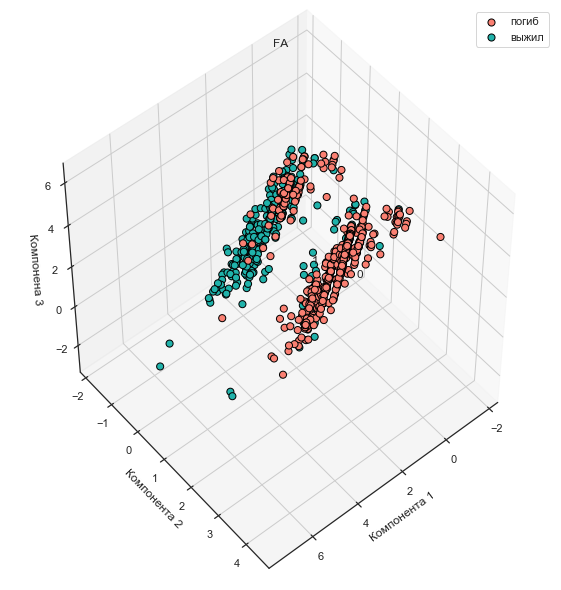

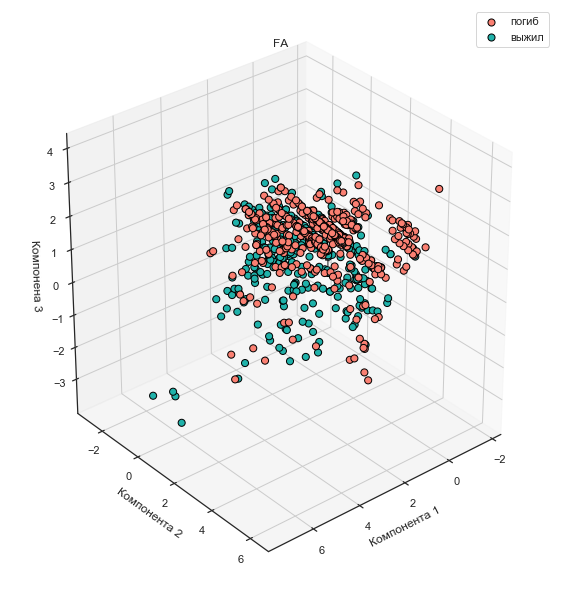

In [39]:
threeD_data (X33, 30, 40, 0, 1, 2, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X33, 50, 50, 0, 2, 1, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')
threeD_data (X33, 30, 50, 0, 1, 4, "FA", 'Компонента 1', 'Компонента 2', 'Компонена 3')

В методе главных компонентов оси ортонормированы. Это жесткое требование. от него можно отказатся применив следующий подход:

In [39]:
pca = FactorAnalysis() #PCA()
S_pca_ = pca.fit(m).transform(m)

ica = FastICA(random_state=None)
S_ica_ = ica.fit(m).transform(m)  # Estimate the sources

S_ica_ /= S_ica_.std(axis=0)

Text(0.5, 1.0, 'ICA recovered signals')

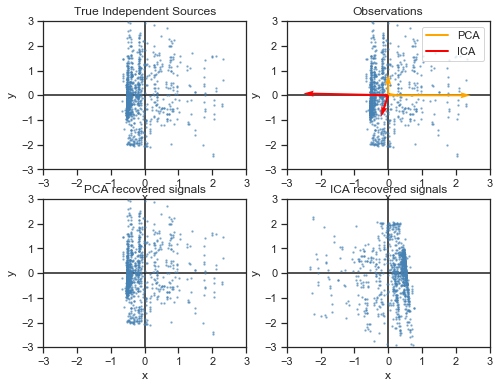

In [53]:
def plot_samples(m, axis_list=None):
    plt.scatter(m.iloc[:,0], m.iloc[:,1], s=2, marker='o', zorder=10,
                color='steelblue', alpha=0.5)
    if axis_list is not None:
        colors = ['orange', 'red']
        for color, axis in zip(colors, axis_list):
            axis /= axis.std()
            x_axis, y_axis = axis
            # Trick to get legend to work
            plt.plot(0.1 * x_axis, 0.1 * y_axis, linewidth=2, color=color)
            plt.quiver(0, 0, x_axis, y_axis, zorder=11, width=0.01, scale=6,
                       color=color)

    plt.hlines(0, -3, 3)
    plt.vlines(0, -3, 3)
    plt.xlim(-3, 3)
    plt.ylim(-3, 3)
    plt.xlabel('x')
    plt.ylabel('y')

plt.figure(figsize=(8, 6))
plt.subplot(2, 2, 1)
plot_samples(X1 / X1.std())
plt.title('True Independent Sources')

axis_list = [pca.components_.T, ica.mixing_]
plt.subplot(2, 2, 2)
plot_samples(X1 / np.std(X1), axis_list=axis_list)
legend = plt.legend(['PCA', 'ICA'], loc='upper right')
legend.set_zorder(100)
plt.title('Observations')

plt.subplot(2, 2, 3)
plot_samples(pd.DataFrame(S_pca_) / np.std(S_pca_, axis=0))
plt.title('PCA recovered signals')

plt.subplot(2, 2, 4)
plot_samples(pd.DataFrame(S_ica_) / np.std(S_ica_))
plt.title('ICA recovered signals')

## Ядровый метод главных компонент

In [29]:
# Ядро rbf, radial basis function
kpca = KernelPCA(n_components=2, kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(dff)
X_back = kpca.inverse_transform(X_kpca)

In [30]:
selector = lambda x: (y == x).values.transpose()[0]

Text(0, 0.5, '2ая главная компонента')

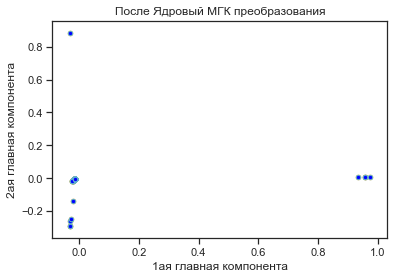

In [31]:
plt.scatter(X_kpca[selector(1) == 1, 0], X_kpca[selector(1) == 1, 1], c="red",
            s=20, edgecolor='orange')
plt.scatter(X_kpca[selector(0) == 0, 0], X_kpca[selector(0) == 0, 1], c="blue",
            s=20, edgecolor='c')
plt.title("После Ядровый МГК преобразования")
plt.xlabel("1ая главная компонента")
plt.ylabel("2ая главная компонента")

In [32]:
kpca = KernelPCA(n_components=2, kernel="rbf", fit_inverse_transform=True, gamma=10)
X_kpca = kpca.fit_transform(dff_st_norm)
X_back = kpca.inverse_transform(X_kpca)

In [33]:
selector = lambda x: (y == x).values.transpose()[0]

Text(0, 0.5, '2ая главная компонента')

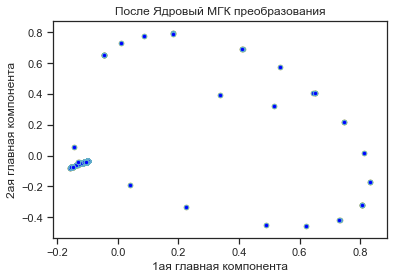

In [34]:
plt.scatter(X_kpca[selector(1) == 1, 0], X_kpca[selector(1) == 1, 1], c="red",
            s=20, edgecolor='orange')
plt.scatter(X_kpca[selector(0) == 0, 0], X_kpca[selector(0) == 0, 1], c="blue",
            s=20, edgecolor='c')
plt.title("После Ядровый МГК преобразования")
plt.xlabel("1ая главная компонента")
plt.ylabel("2ая главная компонента")

### Машинное обучение

#### Дерево решений

In [66]:
# Машинное обучение https://habr.com/ru/company/ods/blog/325654/ потом убрать
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score

# Разделим данные на тестовую и обучающую выборки
X_train, X_test, y_train, y_test = train_test_split(X1_a, y_a, test_size=.3, 
                                                    stratify=y_a, 
                                                    random_state=42)

# Для примера возьмём неглубокое дерево решений
clf = DecisionTreeClassifier(max_depth=5, random_state=42)
clf.fit(X_train, y_train)
preds = clf.predict_proba(X_test) # вероятностные оценки для обоих классов
print('Accuracy: ',accuracy_score(y_test, preds.argmax(axis=1))) # Точность оценок
preds

Accuracy:  0.8152866242038217


array([[0.        , 1.        ],
       [0.81034483, 0.18965517],
       [0.61904762, 0.38095238],
       [0.84      , 0.16      ],
       [0.81034483, 0.18965517],
       [0.81034483, 0.18965517],
       [0.        , 1.        ],
       [0.94166667, 0.05833333],
       [0.        , 1.        ],
       [0.94166667, 0.05833333],
       [0.94166667, 0.05833333],
       [0.81034483, 0.18965517],
       [0.        , 1.        ],
       [0.01680672, 0.98319328],
       [0.01680672, 0.98319328],
       [0.81034483, 0.18965517],
       [0.01680672, 0.98319328],
       [0.81034483, 0.18965517],
       [0.01680672, 0.98319328],
       [0.94166667, 0.05833333],
       [0.94166667, 0.05833333],
       [0.81034483, 0.18965517],
       [0.81034483, 0.18965517],
       [0.94166667, 0.05833333],
       [0.81034483, 0.18965517],
       [0.01680672, 0.98319328],
       [0.81034483, 0.18965517],
       [0.15      , 0.85      ],
       [0.        , 1.        ],
       [0.81034483, 0.18965517],
       [0.

In [67]:
# С использованием цикла
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
# Разделим данные на тестовую и обучающую выборки
def DecisionTree(data, k): # k - количество прогонов
    accuracy = 0
    for i in range(k):
        X_train, X_test, y_train, y_test = train_test_split(data.values, y_a, test_size=.2, 
                                                            stratify=y_a)
    # Для примера возьмём неглубокое дерево решений
        clf = DecisionTreeClassifier(max_depth=5)
        clf.fit(X_train, y_train)
        preds = clf.predict_proba(X_test) # вероятностные оценки для обоих классов
        accuracy += accuracy_score(y_test, preds.argmax(axis=1))
    print('Accuracy: ',accuracy/k) # Точность оценок

In [68]:
DecisionTree(X1, 1000) # PCA по исходным данным
DecisionTree(X2, 1000) # PCA по стандартизированным данным
DecisionTree(X3, 1000) # PCA по стандартизированным и нормированным данным

Accuracy:  0.7965693779904357
Accuracy:  0.7895645933014411
Accuracy:  0.7900382775119663


In [69]:
DecisionTree(X11, 1000) # FA по исходным данным
DecisionTree(X22, 1000) # FA по стандартизированным данным
DecisionTree(X33, 1000) # FA по стандартизированным и нормированным данным

Accuracy:  0.7952966507177076
Accuracy:  0.7887655502392384
Accuracy:  0.7888373205741673


#### Случайный лес

In [72]:
from sklearn.ensemble import RandomForestClassifier
def RandomForest(data, k): # k - количество прогонов
    accuracy = 0
    for i in range(k):
        X_train, X_test, y_train, y_test = train_test_split(data.values, y_a, test_size=.2, 
                                                            stratify=y_a)
    # Для примера возьмём неглубокое дерево решений
        clf = RandomForestClassifier(max_depth=5)
        clf.fit(X_train, y_train)
        preds = clf.predict_proba(X_test) # вероятностные оценки для обоих классов
        accuracy += accuracy_score(y_test, preds.argmax(axis=1))
    print('Accuracy: ',accuracy/k) # Точность оценок

In [73]:
RandomForest(X1, 100)
RandomForest(X2, 100)
RandomForest(X3, 100)

/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Accuracy:  0.8056459330143538


/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Accuracy:  0.7959808612440186


/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Accuracy:  0.791435406698564


/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

In [74]:
RandomForest(X11, 100)
RandomForest(X22, 100)
RandomForest(X33, 100)

/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Accuracy:  0.7999521531100475


/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Accuracy:  0.7950239234449754


/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.",

Accuracy:  0.7966028708133968


/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/Users/natalia_nikitina/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
